# walkthrough of an vine copula (vinecop) application on financial (US ETFs) dependence modeling and simulation.

- data preprocessing and exploratory data analysis
- make marginal cdf/ppf, transform from raw return to copula data
- fit 'rvine', draw, do full simulation
- fit 'cvine', draw, do cond simulation (given **SPY** scenario)


## initialization, fetch data, preprocess


In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yfinance as yf

# * add proj root folder into path so `./tests` folder is searchable
sys.path.append("..")
import torchvinecopulib as tvc

lst_ticker = [
    "SPY",
    "QQQ",
    "DIA",
    "IJH",
    "VTI",
    "IWM",
    "XLF",
    "XLE",
    "XLK",
    "EFA",
    "EWA",
    "EWJ",
    "EEM",
    "FXI",
    "AGG",
    "TLT",
    "GLD",
    "SLV",
    "USO",
    "UNG",
]
print(lst_ticker)
raw_df = yf.download(lst_ticker, start="2010-01-01")
raw_df.index = pd.DatetimeIndex(raw_df.index)
raw_df = raw_df["Adj Close"].ffill()
# calc simple retn
NUM_DAY_INTVL = 1
df_retn_adjclose_simple_last_intvl = np.expm1(np.log(raw_df)[::NUM_DAY_INTVL].diff(1).dropna())
#
NUM_SIM = 50000
print(f"cuda (GPU) avail? {torch.cuda.is_available()}\n")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

['SPY', 'QQQ', 'DIA', 'IJH', 'VTI', 'IWM', 'XLF', 'XLE', 'XLK', 'EFA', 'EWA', 'EWJ', 'EEM', 'FXI', 'AGG', 'TLT', 'GLD', 'SLV', 'USO', 'UNG']


[*********************100%%**********************]  20 of 20 completed


cuda (GPU) avail? True



### chart rolling bidep between each asset and SPY


In [2]:
f_bidep = lambda a, b: tvc.util.kendall_tau(a, b)[0]
dct_dep_spy = {}
for df in df_retn_adjclose_simple_last_intvl.rolling(
    window=252 // NUM_DAY_INTVL, step=int(np.sqrt(252) // NUM_DAY_INTVL)
):
    if df.shape[0] >= 252 // NUM_DAY_INTVL:
        dct_dep_spy[df.index[-1]] = {
            k: f_bidep(torch.from_numpy(df[[k]].values), torch.from_numpy(df[["SPY"]].values))
            for k in df.keys()
        }

Text(0.5, 1.0, 'Rolling bivariate dependence (kendall_tau), between ETFs and SPY.')

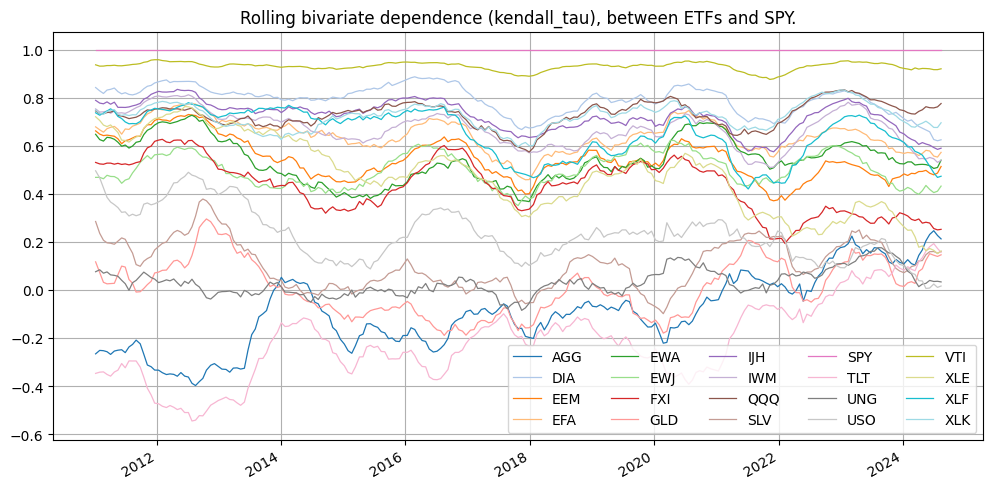

In [3]:
pd.DataFrame(dct_dep_spy).T.plot(figsize=(12, 6), style="-", alpha=1, lw=0.9, colormap="tab20")
plt.legend(ncol=5)
plt.grid()
plt.title(f"Rolling bivariate dependence (kendall_tau), between ETFs and SPY.")

### make marginal cdf_ppf functions; transform from raw data (-∞,∞)-> copula data (0,1)


In [4]:
from scipy import stats
from random import seed as r_seed
from scipy.special import ndtr
from scipy.interpolate import CubicSpline


def make_cdf_ppf(
    vec_obs: np.array,
    mtd_margin: str,
    seed: int = 0,
    lst_distribution: list = [
        stats.norm,
        stats.t,
        stats.nct,
        stats.laplace,
        stats.laplace_asymmetric,
        stats.johnsonsu,
        # stats.tukeylambda,
    ],
) -> pd.Series:
    """fit marginal univariate distributions, return fitted cdf/ppf functions
    # ! band_width for np fit from:
    Dhaker, H., Deme, E. H., & Ciss, Y. (2021).
    β-Divergence loss for the kernel density estimation with bias reduced.
    Statistical Theory and Related Fields, 5(3), 221-231.
    """
    r_seed(seed)
    np.random.seed(seed=seed)
    vec_clean = np.sort(vec_obs[np.isfinite(vec_obs)])
    if mtd_margin == "np":
        # The constant has beta = 1.7320508075688772 from
        # (4 * beta**4 / (9 * beta**4 - 36 * beta**3 + 90 * beta**2 + 270 * beta + 105) * sqrt(2 / pi))**(1 / 9)
        band_width = vec_clean.std() * 0.6973425390765554 * (len(vec_clean)) ** (-1 / 9)

        # empirical cdf, semi parametric approach, from mixture
        @np.vectorize
        def res_cdf(quantile: np.array):
            # ±∞ return to (0,1) cdf
            return ndtr((quantile - vec_clean) / band_width).mean()

        vec_F, idx = np.unique(res_cdf(vec_clean), return_index=True)
        func_spline = CubicSpline(x=vec_F, y=vec_clean[idx])
        eps = 1 / (len(vec_clean) + 1)

        def res_ppf(percentage: np.array):
            # (0,1) cdf to ±∞ return
            return func_spline(np.clip(a=percentage, a_min=eps, a_max=1 - eps))

    elif mtd_margin == "p":
        dist, par, bic2, lnn2 = None, None, np.inf, np.log(len(vec_clean)) / 2
        for iter_dist in lst_distribution:
            iter_par = iter_dist.fit(vec_clean)
            iter_bic2 = len(iter_par) * lnn2 - iter_dist.logpdf(vec_clean, *iter_par).sum()
            if iter_bic2 < bic2:
                dist, par, bic2 = iter_dist, iter_par, iter_bic2
        res_cdf, res_ppf = lambda vec: dist.cdf(vec, *par), lambda vec: dist.ppf(vec, *par)

    return pd.Series({"cdf": res_cdf, "ppf": res_ppf})

In [5]:
arr_cdf_ppf = np.apply_along_axis(
    func1d=lambda vec: make_cdf_ppf(vec_obs=vec, mtd_margin="np", seed=0),
    axis=0,
    arr=df_retn_adjclose_simple_last_intvl.values,
)

In [6]:
V_mvcp = torch.as_tensor(
    np.hstack(
        [
            cdf(df_retn_adjclose_simple_last_intvl.values[:, [idx]])
            for idx, cdf in enumerate(arr_cdf_ppf[0])
        ]
    ),
    device=DEVICE,
)
print(V_mvcp.min(), V_mvcp.max())

tensor(0.0001, device='cuda:0', dtype=torch.float64) tensor(0.9999, device='cuda:0', dtype=torch.float64)


## rvine, full sim
> make rvine from multivariate copula observations, **full sim**

In [7]:
# read tpl_sim from right to left
mdl_vcp = tvc.vinecop.vcp_from_obs(V_mvcp)
print(mdl_vcp)

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 20,
 'num_obs': 3_683,
 'num_par': 125,
 'negloglik': -57391.951,
 'aic': -114533.9021,
 'bic': -113757.4667,
 'matrix': '[[ 0  7  6 11  4  5  2  3  9 15 17  8 19 16 10 14 12  1 18 13]'
           ' [-1  7 14 13 19 10  9 15 18 17  8  1 12  5 16  6  2  3  4 11]'
           ' [-1 -1  6 14 13 19 10  9 15 18 17  8  1 12  5 16 11  4  3  2]'
           ' [-1 -1 -1 11 14 13 19 10  9 15 18 17  8  1 12  5 16  2  3  4]'
           ' [-1 -1 -1 -1  4 14 13 19 10  9 15 18 17  8  1 12  5 16  2  3]'
           ' [-1 -1 -1 -1 -1  5 14 13 19 10  9 15 18 17  8  1 12  2 16  3]'
           ' [-1 -1 -1 -1 -1 -1  2 14 13 19 10  9 15 18 17  8  1 12 16  3]'
           ' [-1 -1 -1 -1 -1 -1 -1  3 14 13 19 10  9 15 18 17  8  1 12 16]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1  9 14 13 19 10 18  1 12 16 15 17  8]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 14 15 17  8 19 16 10 12  1 18 13]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 13 15 17  8 19 16 10 12  1 18]'
           

In [8]:
for _ in enumerate(df_retn_adjclose_simple_last_intvl.columns):
    print(_)

(0, 'AGG')
(1, 'DIA')
(2, 'EEM')
(3, 'EFA')
(4, 'EWA')
(5, 'EWJ')
(6, 'FXI')
(7, 'GLD')
(8, 'IJH')
(9, 'IWM')
(10, 'QQQ')
(11, 'SLV')
(12, 'SPY')
(13, 'TLT')
(14, 'UNG')
(15, 'USO')
(16, 'VTI')
(17, 'XLE')
(18, 'XLF')
(19, 'XLK')


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Level 0, BiDep Metric chatterjee_xi'}>,
 <networkx.classes.graph.Graph at 0x275af0ea470>)

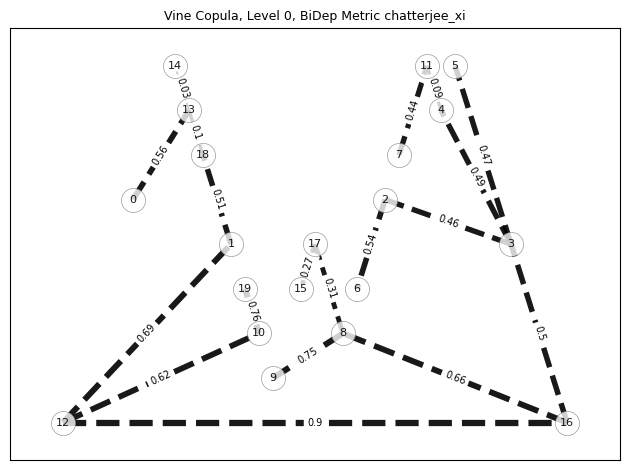

In [9]:
# SPY is vertex 12
mdl_vcp.draw_lv()

In [10]:
print(mdl_vcp.tpl_sim)
V_sim = mdl_vcp.sim(num_sim=NUM_SIM, device=DEVICE)
print(V_sim)

(0, 7, 6, 11, 4, 5, 2, 3, 9, 14, 13, 15, 17, 8, 19, 10, 16, 12, 1, 18)
tensor([[0.4141, 0.9715, 0.9099,  ..., 0.8553, 0.8805, 0.9727],
        [0.6272, 0.7108, 0.9220,  ..., 0.7471, 0.6501, 0.7896],
        [0.1867, 0.4724, 0.6833,  ..., 0.8016, 0.4968, 0.4021],
        ...,
        [0.6606, 0.9539, 0.4485,  ..., 0.9801, 0.9686, 0.3839],
        [0.2221, 0.1078, 0.3207,  ..., 0.1572, 0.1111, 0.2399],
        [0.7350, 0.5019, 0.1329,  ..., 0.5908, 0.3140, 0.3626]],
       device='cuda:0', dtype=torch.float64)


In [11]:
arr_sim = np.hstack([ppf(V_sim[:, [idx]].cpu()) for idx, ppf in enumerate(arr_cdf_ppf[1])])

print(arr_sim.min(), arr_sim.max())
print(
    "\nkendall tau wrt SPY, of simulations\n",
    pd.DataFrame(arr_sim, columns=df_retn_adjclose_simple_last_intvl.columns).corr(
        method="kendall"
    )["SPY"],
)
print(
    "\nkendall tau wrt SPY, of raw obs\n",
    df_retn_adjclose_simple_last_intvl.corr(method="kendall")["SPY"],
)

-0.25333389863349143 0.1796019650999746

kendall tau wrt SPY, of simulations
 Ticker
AGG   -0.072938
DIA    0.787356
EEM    0.555591
EFA    0.645292
EWA    0.563737
EWJ    0.505632
FXI    0.425857
GLD    0.040760
IJH    0.718399
IWM    0.667258
QQQ    0.737050
SLV    0.137271
SPY    1.000000
TLT   -0.199508
UNG    0.014467
USO    0.250957
VTI    0.931269
XLE    0.475120
XLF    0.643754
XLK    0.725468
Name: SPY, dtype: float64

kendall tau wrt SPY, of raw obs
 Ticker
AGG   -0.073750
DIA    0.788035
EEM    0.548424
EFA    0.643591
EWA    0.548818
EWJ    0.499973
FXI    0.426002
GLD    0.028381
IJH    0.719956
IWM    0.670589
QQQ    0.736727
SLV    0.132134
SPY    1.000000
TLT   -0.199495
UNG    0.040863
USO    0.230482
VTI    0.931712
XLE    0.461276
XLF    0.639397
XLK    0.723849
Name: SPY, dtype: float64


## rvine, cond sim
> make rvine from multivariate copula observations, **cond sim**

In [12]:
# user specify the priority vertices list, used in fitting and also in the conditional simulation
mdl_vcp_cond = tvc.vinecop.vcp_from_obs(
    V_mvcp,
    mtd_vine="rvine",
    tpl_first=(12,),
)

print(mdl_vcp_cond)

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 20,
 'num_obs': 3_683,
 'num_par': 125,
 'negloglik': -57391.951,
 'aic': -114533.9021,
 'bic': -113757.4667,
 'matrix': '[[ 0  7  6 11  4  5  2  3  9 15 17  8 19 16 10 14 12  1 18 13]'
           ' [-1  7 14 13 19 10  9 15 18 17  8  1 12  5 16  6  2  3  4 11]'
           ' [-1 -1  6 14 13 19 10  9 15 18 17  8  1 12  5 16 11  4  3  2]'
           ' [-1 -1 -1 11 14 13 19 10  9 15 18 17  8  1 12  5 16  2  3  4]'
           ' [-1 -1 -1 -1  4 14 13 19 10  9 15 18 17  8  1 12  5 16  2  3]'
           ' [-1 -1 -1 -1 -1  5 14 13 19 10  9 15 18 17  8  1 12  2 16  3]'
           ' [-1 -1 -1 -1 -1 -1  2 14 13 19 10  9 15 18 17  8  1 12 16  3]'
           ' [-1 -1 -1 -1 -1 -1 -1  3 14 13 19 10  9 15 18 17  8  1 12 16]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1  9 14 13 19 10 18  1 12 16 15 17  8]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 14 15 17  8 19 16 10 12  1 18 13]'
           ' [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 13 15 17  8 19 16 10 12  1 18]'
           

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Level 0, BiDep Metric chatterjee_xi'}>,
 <networkx.classes.graph.Graph at 0x275af3ee7d0>)

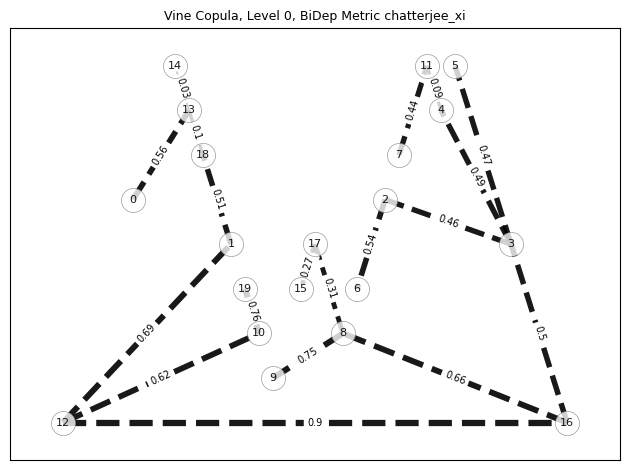

In [13]:
# SPY is vertex 12
mdl_vcp_cond.draw_lv()

In [14]:
# cond sim: user specified values for first set (vertex 12),
# a tail scenario with CDF(SPY)=.05
dct_first_vs = {(12, frozenset()): torch.ones(size=(NUM_SIM, 1), device=DEVICE) * (0.05)}
V_sim_cond = mdl_vcp.sim(num_sim=NUM_SIM, dct_first_vs=dct_first_vs, device=DEVICE)
arr_sim_cond = np.hstack(
    [ppf(V_sim_cond[:, [idx]].cpu()) for idx, ppf in enumerate(arr_cdf_ppf[1])]
)
print("specified value of SPY:", arr_sim_cond[:, 12])
print(arr_sim_cond[:3, :])

specified value of SPY: [-0.0171818 -0.0171818 -0.0171818 ... -0.0171818 -0.0171818 -0.0171818]
[[ 3.16365309e-04  1.91535383e-02 -1.10657316e-01 -1.47828367e-02
  -1.32225099e-01 -4.30182872e-03 -1.02029034e-01 -4.77131791e-02
   1.50928547e-04 -1.40908596e-03 -5.90870431e-02 -1.26561213e-01
  -1.71817962e-02  1.94894680e-03 -3.08462002e-03  3.11116658e-02
  -2.22826112e-02  5.83192745e-02  1.43193108e-02 -5.05481827e-02]
 [-1.81352899e-03 -3.45133400e-03 -2.39842466e-03 -1.36186838e-02
  -3.18880792e-03 -3.97303237e-03  9.39706069e-03  4.16370880e-03
  -2.85003573e-02 -2.34278055e-02 -2.60225149e-02  2.44697487e-03
  -1.71817962e-02 -2.79905687e-02  5.59990905e-02  7.00584910e-03
  -1.82032898e-02  1.91779083e-02 -8.31531662e-03 -2.06301344e-02]
 [-6.99255435e-05 -3.17301640e-03 -1.75772113e-02 -1.10657990e-02
  -1.65626855e-02 -8.53847466e-03 -1.92892630e-02 -1.14067213e-02
  -1.45806376e-02 -1.22802793e-02 -3.86223602e-02 -4.23472579e-04
  -1.71817962e-02  1.19337483e-03  4.7840981